In [1]:
import pandas as pd
import numpy as np
import pathlib
from scipy import constants
from pprint import pprint
import matplotlib.pyplot as plt
if True:
    import sys
    sys.path.append("/home/salmon/workspace/fytok/python")
    sys.path.append("/home/salmon/workspace/SpDB/python")
    sys.path.append("/home/salmon/workspace/SpView/python")

    from fytok.load_profiles import (load_core_profiles, load_core_source,
                                     load_core_transport, load_equilibrium)
    from fytok.modules.transport.Equilibrium import Equilibrium
    from fytok.numlib.smooth import rms_residual
    from spdm.data import File, Function, Query
    from spdm.logger import logger
    from spdm.view.plot_profiles import plot_profiles, sp_figure


###########################


In [2]:
#eqdsk_file = File("/home/salmon/workspace/data/15MA inductive - burn/Standard domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16HR.txt", format="geqdsk").read()

eqdsk_file = File("/home/salmon/workspace/fytok/test.geqdsk", format="geqdsk").read()

desc = load_equilibrium(eqdsk_file,
                        coordinate_system={
                            "psi_norm": np.linspace(0.0,  0.995, 128),
                            "theta": 64},
                        code={"name": "dummy"},
                        boundary={"psi_norm": 0.995}
                        )
eq = Equilibrium(desc)
psi_norm = np.linspace(0.0, 0.995, 32)


2022-11-09 15:29:59,914 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/sp_export.py:101:sp_find_module_by_name: Load module spdm.plugins.data.file.PluginGEQdsk
2022-11-09 15:29:59,916 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/data/File.py:65:__init__: Open GEQdskFile: /home/salmon/workspace/fytok/test.geqdsk mode='r'
2022-11-09 15:29:59,919 DEBUG [spd] /home/salmon/workspace/fytok/python/spdm/plugins/data/file/PluginGEQdsk.py:292:__init__: Open File /home/salmon/workspace/fytok/test.geqdsk mode=r
2022-11-09 15:29:59,954 DEBUG [spd] /home/salmon/workspace/SpDB/python/spdm/sp_export.py:101:sp_find_module_by_name: Load module fymodules.transport.equilibrium.dummy


/fuyun/software/SciPy-bundle/2020.11-foss-2020b/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


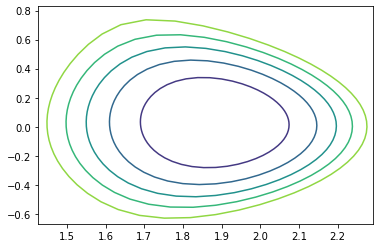

In [4]:
plt.contour(eq.profiles_2d.r,eq.profiles_2d.z,eq.profiles_2d.psi(eq.profiles_2d.r,eq.profiles_2d.z))

<AxesSubplot:>

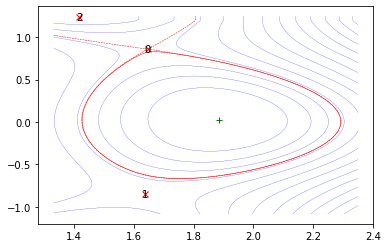

In [7]:
eq.plot(
    boundary=True,
    separatrix=True,
    contour=np.linspace(0,5,20),)



In [6]:
eq.profiles_2d._coord.critical_points

([OXPoint(r=1.8847588093508452, z=0.02845740705088884, psi=-0.4638916970242094)],
 [OXPoint(r=1.6460039548925296, z=0.85920496003406, psi=-0.3829623739289616),
  OXPoint(r=1.6373424474992366, z=-0.8508071918560404, psi=-0.3690912430010435),
  OXPoint(r=1.4161614404532614, z=1.2398329413384195, psi=-0.4363716687011516)])

In [25]:
def sp_ATEC_to_equilibrium_profiles_2d(fpath):
    def _read_data(fid, count, width=16):
        data = []
        for n in range(count):
            data.append(float(fid.read(width)))
            if n >= count - 1 or ((n + 1) % 5 == 0):
                fid.readline()
            else:
                fid.read(1)
        data = np.asarray(data)
        return data

    profiles_2d = {"grid_type": {"name": "rectangular", "index": 1}}

    with open(fpath,  mode="r") as fid:

        nw = int(fid.read(5))
        fid.read(1)
        nh = int(fid.read(5))
        fid.readline()

        data = _read_data(fid, nw*nh+nw+nh, width=20)

        psirz = data[:nw*nh].reshape([nh, nw])
        dim1 = data[nw*nh::2]
        dim2 = data[nw*nh+1::2]

        profiles_2d["grid"] = {"dim1": dim1, "dim2": dim2, }

        profiles_2d["psi"] = psirz

    return {"equilibrium": {"profiles_2d": profiles_2d}}


In [26]:
dd = sp_ATEC_to_equilibrium_profiles_2d("/home/salmon/workspace/atec/ATEC_craft/eqoutput")

dd["equilibrium"]["vacuum_toroidal_field"] = {"b0": 5, "r0": 4.0, }
dd["equilibrium"]["global_quantities"] = {"ip": 1e6}

eq_new = Equilibrium(dd["equilibrium"])


<AxesSubplot:>

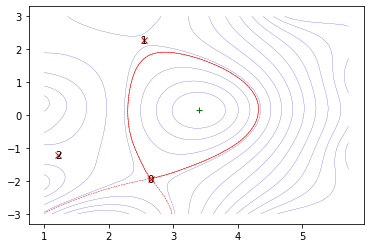

In [27]:
eq_new.plot(
    boundary=True,
    separatrix=True,
    contour=np.linspace(0,5,20),)